In [1]:
from importlib import reload
import numpy as np
import torch
import matplotlib.pyplot as plt

import lab3
reload(lab3)

import lab3.classes
reload(lab3.classes)
import lab3.classes as cs

import lab3.show
reload(lab3.show)
from lab3.show import display_img_with_masks

import lab3.trans
reload(lab3.trans)
from lab3.trans import validation_trans, train_trans, test_trans

import lab3.dataset
reload(lab3.dataset)
from lab3.dataset import FiftyOneDataset

import lab3.net
reload(lab3.net)
from lab3.net import Net

import lab1.device
reload(lab1.device)
from lab1.device import device

import lab3.util
reload(lab3.util)
from lab3.util import seconds_to_time

device

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


device(type='mps')

In [2]:
from typing import Literal
import fiftyone as fo
import fiftyone.utils.openimages as fouo
import fiftyone.zoo as foz

def download(split = "train", max_samples: int = 2000):
  return foz.load_zoo_dataset(
    "open-images-v6",
    split        = split,
    label_types  = ["segmentations", "detections"],
    classes      = cs.classes_no_background,
    max_samples  = max_samples,
    dataset_dir  = "data-lab3",
    dataset_name =f"open-images-v6-{split}"
  )

def load(split = "train"):
  dataset =  fouo.OpenImagesV6DatasetImporter(
    dataset_dir = f"data-lab3/{split}",
    label_types = "segmentations"
  )

  dataset.setup()

  return dataset

# train_ds = download("train")
# valid_ds = download("validation", max_samples = 300)
# test_ds  = download("test", max_samples = 300)

train_ds = load("train")
valid_ds = load("validation")

train_ds #, fo.list_datasets()

In [3]:
import torch

train_dataset = FiftyOneDataset(train_ds, train_trans)
valid_dataset = FiftyOneDataset(valid_ds, validation_trans)

num_workers = 8
batch_size = 512

train_ld = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
valid_ld = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, num_workers = num_workers, shuffle = False)

print(f'Train: {len(train_dataset)}, Test: {len(valid_dataset)}')

Train: 808, Test: 157


In [5]:
from sklearn.metrics import f1_score
from torch import cat as c
from torch import tensor as t

def evaluate(model, loader):
  print(f"Evaluating")
  model.eval()

  dice = 0
  iou  = 0

  y_hats = torch.zeros(0, 6, 128, 128) < 1
  ys = torch.zeros(0, 6, 128, 128) < 1

  ix = -1
  for images, true_masks in loader:
    images = images.to(device)
    true_masks = true_masks.cpu().detach()

    with torch.no_grad():
      predictions = model(images)
    predictions = predictions.cpu().detach()

    true_masks = true_masks > 0.5
    predictions = predictions > 0.5

    y_hats = c((y_hats, predictions), dim = 0)
    ys = c((ys, true_masks), dim = 0)

    ix -= 1
    if ix == 0:
      break

  intersection = torch.bitwise_and(ys, y_hats)
  union = torch.bitwise_or(ys, y_hats)

  intersection = torch.sum(intersection)
  union = torch.sum(union)

  # Jaccard = || A \intersect B || / || A \union B ||
  iou = intersection / union

  # DICE = 2 || A \intersect B || / (||A|| + ||B||)
  dice = 2 * intersection / (torch.sum(ys) + torch.sum(y_hats))

  # Flatten the tensors
  ys_flat = ys.view(-1).numpy()
  y_hats_flat = y_hats.view(-1).numpy()

  # Calculate Micro-F1 and Macro-F1 scores
  micro_f1 = f1_score(ys_flat, y_hats_flat, average='micro')
  macro_f1 = f1_score(ys_flat, y_hats_flat, average='macro')

  return iou.item(), dice.item(), micro_f1.item(), macro_f1.item()

In [6]:
def train_epoch(optimizer, loss_func, model, loader):
  model.train()
  loss_acum = np.array([], dtype = np.float32)

  for images, mask in loader:
    images = images.to(device)
    mask = mask.to(device)

    pred = model(images)
    loss = loss_func(pred, mask)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [10]:
from datetime import datetime

def train_and_eval(model, train_ld, valid_ld, epoch_count = 10, learning_rate = 1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  start_time = datetime.now()

  train_iou_acum  = []
  train_dice_acum = []
  train_micro_acum = []
  train_macro_acum = []
  valid_iou_acum  = []
  valid_dice_acum = []
  valid_micro_acum = []
  valid_macro_acum = []
  for epoch in range(epoch_count):
    loss = train_epoch(optimizer, loss_func, model, train_ld)
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'loss        | Elapsed: {elapsed}')

    train_iou, train_dice, train_micro, train_macro = evaluate(model, train_ld)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'eval train  | Elapsed: {elapsed}')

    current_time = datetime.now()
    
    valid_iou, valid_dice, valid_micro, valid_macro = evaluate(model, valid_ld)
    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'eval valid  | Elapsed: {elapsed}')

    train_iou_acum.append(train_iou)
    valid_iou_acum.append(valid_iou)
    train_dice_acum.append(train_dice)
    valid_dice_acum.append(valid_dice)
    train_micro_acum.append(train_micro)
    train_macro_acum.append(train_macro)
    valid_micro_acum.append(valid_micro)
    valid_macro_acum.append(valid_macro)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'valid_iou   | Elapsed: {elapsed}')

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
    print(f'  Training IoU:  {train_iou}, Validation IoU:  {valid_iou}')
    print(f'  Training Dice: {train_dice}, Validation Dice: {valid_dice}')
    print(f'  Training Micro: {train_micro}, Validation Micro: {valid_micro}')
    print(f'  Training Macro: {train_macro}, Validation Macro: {valid_macro}')

  return train_iou_acum, valid_iou_acum, train_dice_acum, valid_dice_acum, train_micro_acum, valid_micro_acum, train_macro_acum, valid_macro_acum

In [11]:
def plot(train, valid, label = "IoU"):
  plt.clf()
  plt.plot(train, 'b', label = f'Training {label}')
  plt.plot(valid, 'r', label = f'Validation {label}')
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

Parameter count: 441,318
Training: new epoch
loss        | Elapsed: 59s
Evaluating
eval train  | Elapsed: 2m16s
Evaluating
eval valid  | Elapsed: 3m26s
valid_iou   | Elapsed: 3m26s
Epoch: 0, Time: 3m26s, Training loss: 0.0069580767303705215
  Training IoU:  0.0, Validation IoU:  0.0
  Training Dice: 0.0, Validation Dice: 0.0
  Training Micro: 0.3333333333333333, Validation Micro: 0.3333333333333333
  Training Macro: 0.25, Validation Macro: 0.25
Training: new epoch
loss        | Elapsed: 4m29s
Evaluating
eval train  | Elapsed: 5m49s
Evaluating
eval valid  | Elapsed: 7m0s
valid_iou   | Elapsed: 7m0s
Epoch: 1, Time: 7m0s, Training loss: 0.0069272276014089584
  Training IoU:  0.0, Validation IoU:  0.0
  Training Dice: 0.0, Validation Dice: 0.0
  Training Micro: 0.34215223356442087, Validation Micro: 0.3333333333333333
  Training Macro: 0.2549280364834249, Validation Macro: 0.25
Training: new epoch
loss        | Elapsed: 8m13s
Evaluating
eval train  | Elapsed: 9m29s
Evaluating
eval valid  |

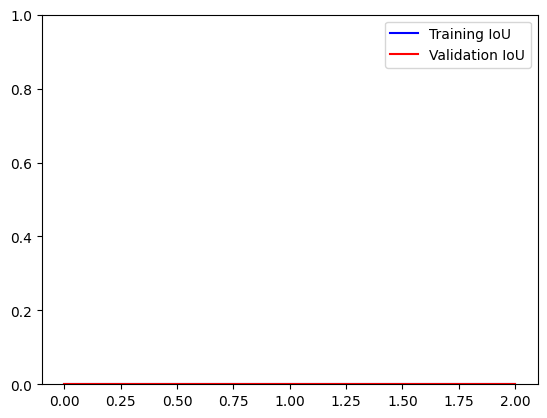

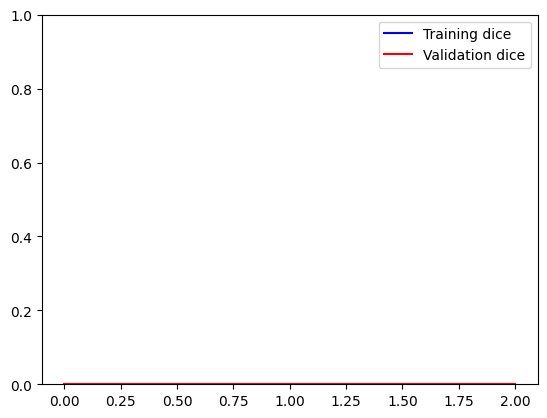

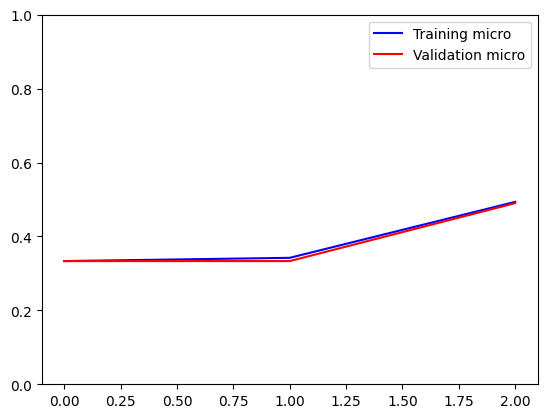

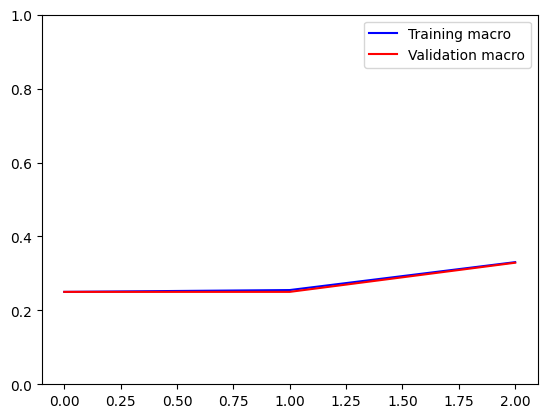

In [12]:
model = Net(train_dataset[0][0].shape[0], num_classes = cs.num_classes).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

EPOCHS = 5

train_iou, valid_iou, train_dice, valid_dice, train_micro, valid_micro, train_macro, valid_macro = train_and_eval(model, train_ld, valid_ld, epoch_count = EPOCHS, learning_rate = 1e-3)
plot(train_iou, valid_iou)
plot(train_dice, valid_dice, label = "dice")
plot(train_micro, valid_micro, label = "micro")
plot(train_macro, valid_macro, label = "macro")

In [13]:
torch.save(model, 'lab3/model_attempt1.pth')

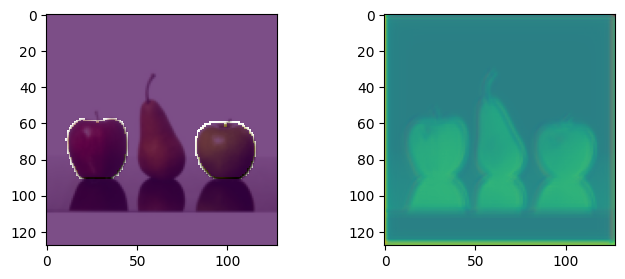

In [14]:
model = torch.load('lab3/model_attempt1.pth').to(device)

img, true_mask = valid_dataset[40]
y = true_mask
mask = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze(0)

# aggregated_mask = lab3.dataset.aggregate_detections(mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (8, 3))
display_img_with_masks(ax1, img, true_mask)
display_img_with_masks(ax2, img, mask)